In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import simtk.openmm as mm
from torsionfit import TorsionScanSet as ScanSet
import torsionfit.TorsionFitModel as Model
from torsionfit import sqlite_plus
from pymc import MCMC
from parmed.charmm import CharmmParameterSet
from torsionfit import plots
from matplotlib.backends.backend_pdf import PdfPages

/Users/chayastern/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [35]:
param_to_opt=[('CG331', 'CG321', 'CG321', 'CG331')]
param = CharmmParameterSet('../data/charmm_ff/top_all36_cgenff.rtf', '../data/charmm_ff/par_all36_cgenff.prm')
structure = 'structure/butane.psf'
scan = 'MP2_torsion_scan/'
# Print initial guess
print param.dihedral_types[param_to_opt[0]]
# Turn off torsion
param.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][1].phi_k=0
param.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][0].phi_k=0

<DihedralTypes [<DihedralType; phi_k=0.038, per=2, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=0.032, per=6, phase=180.000,  scee=1.000, scnb=1.000>]>


In [36]:
butane_scan = ScanSet.parse_psi4_out(scan, structure)
butane_scan.compute_energy(param)

[Psi /Users/chayastern/src/ChayaSt/Torsions/examples/butane/MP2_torsion_scan/0/butane_0.out2 WARNING] In logfileparser.py, line 467, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/chayastern/src/ChayaSt/Torsions/examples/butane/MP2_torsion_scan/10/butane_10.out2 WARNING] In logfileparser.py, line 467, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/chayastern/src/ChayaSt/Torsions/examples/butane/MP2_torsion_scan/20/butane_20.out2 WARNING] In logfileparser.py, line 467, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/chayastern/src/ChayaSt/Torsions/examples/butane/MP2_torsion_scan/30/butane_30.out2 WARNING] In logfileparser.py, line 467, line not all dashes as expected: ------------------------------------------

In [37]:
optimized = butane_scan.remove_nonoptimized()
optimized.compute_energy(param)

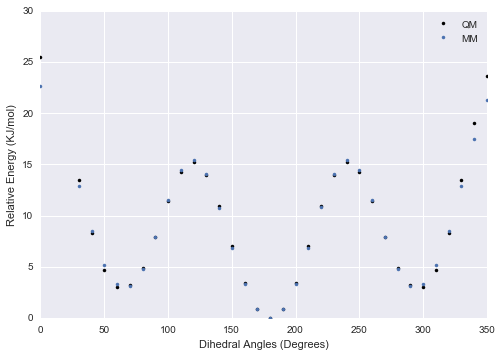

In [38]:
plt.plot(optimized.steps, optimized.qm_energy, 'k.', label='QM')
plt.plot(optimized.steps, optimized.mm_energy, '.', label='MM')
plt.xlabel('Dihedral Angles (Degrees)')
plt.ylabel('Relative Energy (KJ/mol)')
plt.legend()

In [6]:
platform = mm.Platform.getPlatformByName('Reference')

In [7]:
model = Model.TorsionFitModelEliminatePhase(param, optimized, platform=platform, 
                                            param_to_opt=param_to_opt)

In [8]:
sampler = MCMC(model.pymc_parameters, db=sqlite_plus, dbname='butane_n_init_0.database', verbose=5)

In [9]:
sampler.sample(10000)

Assigning step method Metropolis to stochastic log_sigma
Assigning step method Metropolis to stochastic BUTA1_offset
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_4_K
Assigning step method DiscreteMetropolis to stochastic CG331_CG321_CG321_CG331_multiplicity_bitstring
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_2_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_6_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_3_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_1_K
 [-----------------100%-----------------] 10000 of 10000 complete in 388.1 sec

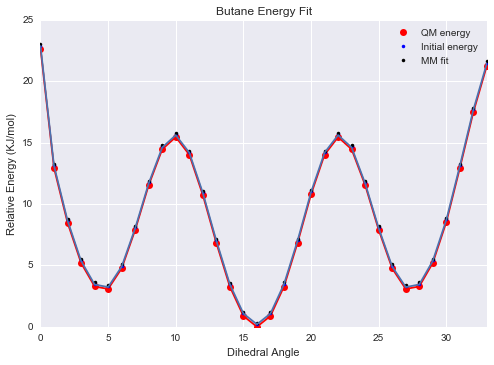

In [49]:
plt.plot(optimized.mm_energy, 'ro', label='QM energy')
plt.plot(optimized.mm_energy, color='r')
plt.plot(db.trace('mm_energy')[0], 'b.', label='Initial energy')
plt.plot(db.trace('mm_energy')[-1], 'k.', label='MM fit')

seaborn.tsplot(db.trace('mm_energy')[:])
plt.legend()
plt.xlabel('Dihedral Angle')
plt.ylabel('Relative Energy (KJ/mol)')
plt.title('Butane Energy Fit')
plt.savefig('Energy_fit_n.pdf')

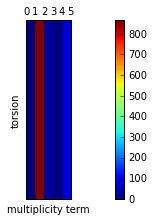

In [11]:
plots.marg_mult(model, sampler, 10000, 0, 'multiplicity.png')

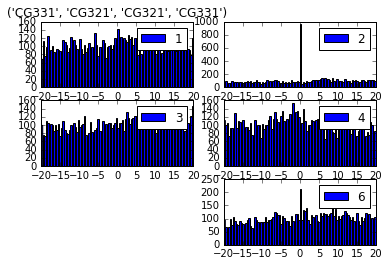

In [12]:
db = sqlite_plus.load('butane_n_init_0.database')
multiplicities = ['1', '2', '3', '4', '6']
with PdfPages('param_hist.pdf') as pdf:
    for torsion in param_to_opt:
        torsion_name = torsion[0] + '_' + torsion[1] + '_' + torsion[2] + '_' + torsion[3]
        for n, m in enumerate(multiplicities):
            if n==1:
                plt.title(torsion)
            plt.subplot(3, 2, int(m))
            k = torsion_name + '_' + m + '_K'
            plt.hist(getattr(db, k)[:], bins=100, label=m)
            plt.legend()
        pdf.savefig()
        plt.show()
        plt.close()

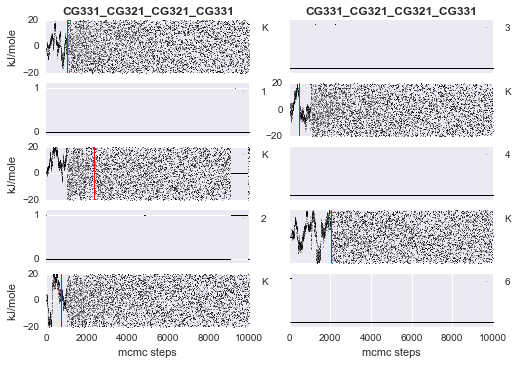

In [2]:
import seaborn
db = sqlite_plus.load('butane_n_init_0.database')
plots.trace_no_phase('CG331_CG321_CG321_CG331', db, markersize=1.0, filename='trace_n_init_0.pdf')

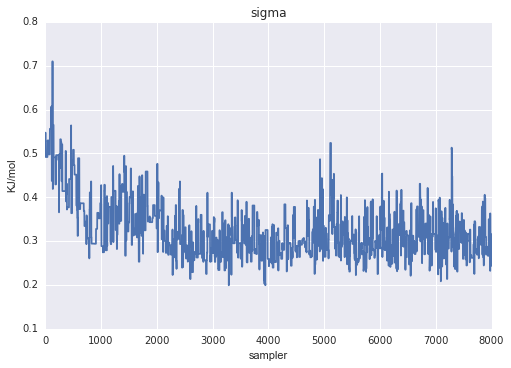

In [33]:
import numpy as np
plt.plot(np.exp(sampler.log_sigma.trace[2000:]))
plt.title('sigma')
plt.xlabel('sampler')
plt.ylabel('KJ/mol')
plt.savefig('sigma_n.png')

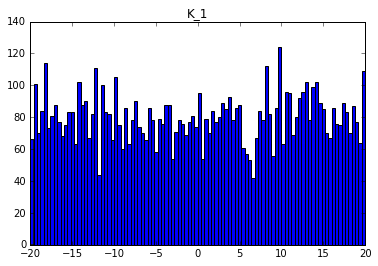

In [13]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_1_K')[2000:], bins=100)
plt.title('K_1')

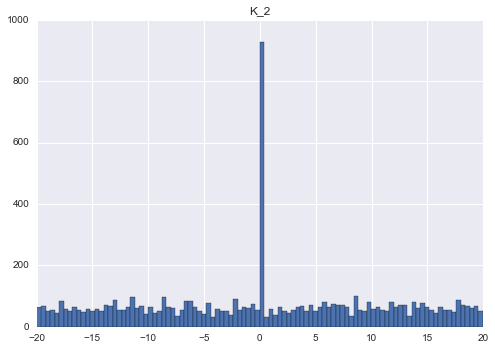

In [33]:
plt.hist(db.trace('CG331_CG321_CG321_CG331_2_K')[3000:], bins=100)
plt.title('K_2')

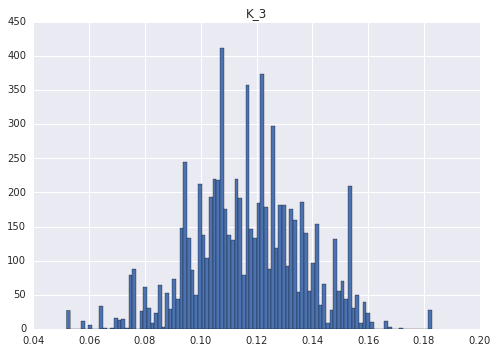

In [36]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_3_K')[2000:], bins=100)
plt.title('K_3')

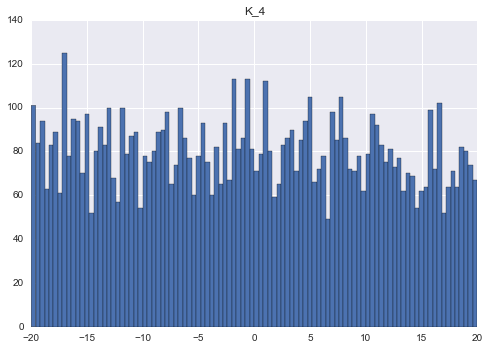

In [34]:
plt.hist(db.trace('CG331_CG321_CG321_CG331_4_K')[2000:], bins=100)
plt.title('K_4')

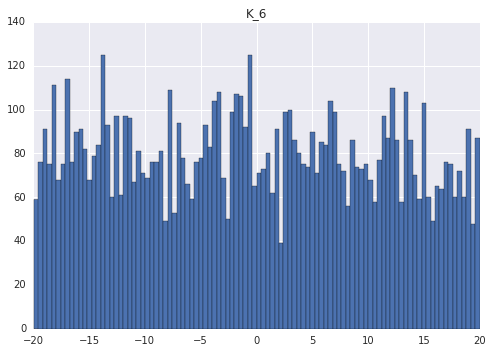

In [38]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_6_K')[2000:], bins=100)
plt.title('K_6')

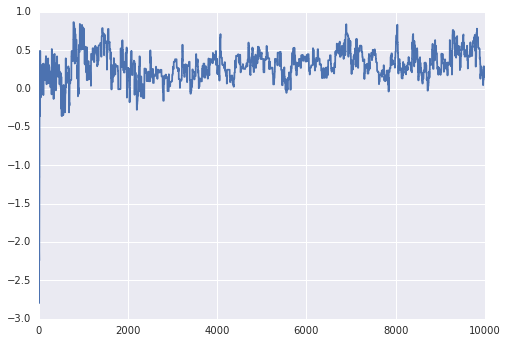

In [28]:
plt.plot(sampler.BUTA1_offset.trace[:])

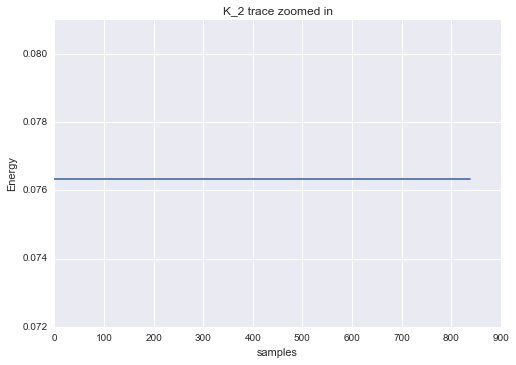

In [66]:
plt.plot(db.CG331_CG321_CG321_CG331_2_K[9077:9915])
plt.xlabel('samples')
plt.ylabel('Energy')
plt.title('K_2 trace zoomed in')
plt.savefig('K_2_zoomed.png')

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,  100.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]),
 array([-0.423654, -0.403654, -0.383654, -0.363654, -0.343654, -0.323654,
        -0.303654, -0.283654, -0.263654, -0.243654, -0.223654, -0.203654,
        -0.183654, -0.163654, -0.143654, -0.123654, -0.103654, -0.083654,
        -0.063654, -0.043654, -0.023654, -0.003654,  0.016346,  0.036346,
         0.056346,  0.076346,  0.096346,  0.116346,  0.136346,  0.156346,
         0.176346,  0.196346,  0.216346,  0.236346,  0.256346,  0.276346,
         0.296346,  0.316346,  0.336346,  0.356346,  0.376346,  0.396346,
         0.416346,  0.436346,  0.456346,  0.476346,  0.496346,  0.516346,
        

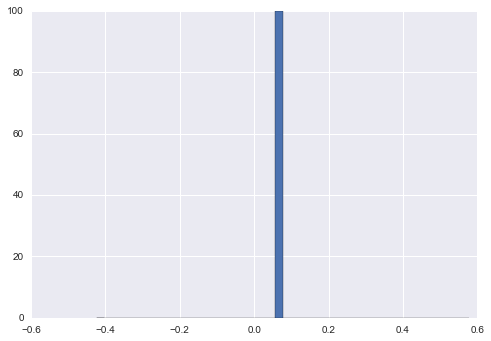

In [11]:
plt.hist(db.CG331_CG321_CG321_CG331_2_K[9500:9600], bins=50)